# Accidents over the time

In the prototyping phase, it was already possible to establish that the `statusId` of a race result contains information about an accident.

**Info:** The `statusId` of a race result indicates how a driver finished the race. In the F1 API, it is also referred to as *‘Finish Status ’*

There are many different `statusId` that need to be analysed in a first phase to find out which IDs declare an accident.
The following list contains all `statusId`, whereby those we have declared as an accident are marked in **bold**:

| ID     | Name           | Beschreibung                                                                 |
|--------|----------------|------------------------------------------------------------------------------|
| 1      | Finished       | Fahrer hat das Rennen regulär beendet                                        |
| 2      | Disqualified   | Fahrer wurde nachträglich disqualifiziert                                    |
| **3**  | **Accident**   | **Ausfall durch Unfall**                                                     |
| **4**  | **Collision**  | **Ausfall durch Kollision mit anderem Fahrer**                               |
| 5      | Engine         | Technischer Ausfall am Motor                                                 |
| 6      | Gearbox        | Ausfall durch Getriebeschaden                                                |
| 7      | Transmission   | Probleme mit dem Antriebsstrang                                              |
| 8      | Clutch         | Kupplungsausfall                                                             |
| 9      | Hydraulics     | Ausfall durch hydraulische Probleme                                          |
| 10     | Electrical     | Elektrikprobleme                                                             |
| 11     | +1 Lap         | Fahrer beendete das Rennen eine Runde hinter dem Sieger                      |
| 12     | +2 Laps        | Zwei Runden Rückstand                                                        |
| 13     | +3 Laps        | Drei Runden Rückstand                                                        |
| 14     | +4 Laps        | Vier Runden Rückstand                                                        |
| 15     | +5 Laps        | Fünf Runden Rückstand                                                        |
| 16     | +6 Laps        | Sechs Runden Rückstand                                                       |
| 17     | +7 Laps        | Sieben Runden Rückstand                                                      |
| 18     | +8 Laps        | Acht Runden Rückstand                                                        |
| 19     | +9 Laps        | Neun Runden Rückstand                                                        |
| **20** | **Spun off**   | **Fahrer verlor Kontrolle und schied durch Dreher aus**                      |
| 21     | Radiator       | Ausfall durch Kühlerprobleme                                                 |
| 22     | Suspension     | Ausfall durch Fahrwerkschaden                                                |
| 23     | Brakes         | Ausfall durch Bremsversagen                                                  |
| 24     | Differential   | Probleme mit dem Differenzial                                                |
| 25     | Overheating    | Ausfall durch Überhitzung                                                    |
| 26     | Mechanical     | Sonstiger mechanischer Defekt                                                |
| 27     | Tyre           | Probleme mit den Reifen (z. B. beschädigt oder falscher Druck)               |
| 28     | Driver Seat    | Problem mit dem Fahrersitz (sehr selten)                                     |
| 29     | Puncture       | Reifenschaden durch Platten                                                  |
| 30     | Driveshaft     | Antriebswelle defekt                                                         |

In [14]:
status_ids_of_interest = [2, 4, 20]

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, sum, round, when, col, first
import matplotlib.pyplot as plt

In [16]:
spark = SparkSession \
    .builder \
    .appName("F1") \
    .getOrCreate()

In [17]:
!hdfs dfs -ls /f1/data/cleaned_*.parquet

Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-05-28 21:56 /f1/data/cleaned_circuits.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup       3359 2025-05-28 21:56 /f1/data/cleaned_circuits.parquet/part-00000-fb3403c2-e9eb-42c6-a1a1-d4bc3c225313-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:30 /f1/data/cleaned_constructor_results.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup      80657 2025-04-27 17:30 /f1/data/cleaned_constructor_results.parquet/part-00000-23998559-62d1-4e57-baa4-d4d192fefdfc-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-05-28 20:24 /f1/data/cleaned_constructor_standings.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup      78562 2025-05-28 20:24 /f1/data/cleaned_constructor_standings.parquet/part-00000-bc29a9a4-b6ae-4024-8cb5-64d38922d652-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-05-28 20:24 /f1/data/cleaned_constructo

In [18]:
results_df = spark.read.parquet(f"/f1/data/cleaned_results.parquet")
races_df = spark.read.parquet(f"/f1/data/cleaned_races.parquet")
constructors_df = spark.read.parquet(f"/f1/data/cleaned_constructors.parquet")
drivers_df = spark.read.parquet(f"/f1/data/cleaned_drivers.parquet")

In [19]:
results_df.show(5)
races_df.show(5)
constructors_df.show(5)
drivers_df.show(5)

+--------+------+--------+-------------+--------+------+--------+
|resultId|raceId|driverId|constructorId|position|points|statusId|
+--------+------+--------+-------------+--------+------+--------+
|       1|    18|       1|            1|       1|  10.0|       1|
|       2|    18|       2|            2|       2|   8.0|       1|
|       3|    18|       3|            3|       3|   6.0|       1|
|       4|    18|       4|            4|       4|   5.0|       1|
|       5|    18|       5|            1|       5|   4.0|       1|
+--------+------+--------+-------------+--------+------+--------+
only showing top 5 rows

+------+---------+----+-----+--------------------+----------+----------+
|raceId|circuitId|year|round|                name|      date|quali_date|
+------+---------+----+-----+--------------------+----------+----------+
|     1|        1|2009|    1|Australian Grand ...|2009-03-29|        \N|
|     2|        2|2009|    2|Malaysian Grand Prix|2009-04-05|        \N|
|     3|       1

# 1. Has the sport become safer over time?
In this chapter we want to find out how the accidents have developed over the time.

To do this, we first need to select the relevant information. The following steps were taken to do this:

1. Join the races to the results
2. Group the results by the year
3. Aggregate the information
    - count all the results per year
    - count all the accidents per year
    - count all accidents that are registered as accident per year
    - count all accidents that are registered as collisions per year
    - count all accidents that are registered as spun off per year
    - calculate the accident rate in relation to all results per year
4. Sort the list by year

In [20]:
accidents_per_year_df = results_df.join(
        races_df.select("raceId", "year"),
        on="raceId",
        how="inner"
    ).groupBy("year") \
    .agg(
        count("*").alias("total_results"),
        sum(when(col("statusId").isin(status_ids_of_interest), 1).otherwise(0)).alias("total_accident_results"),
        sum(when(col("statusId") == 3, 1).otherwise(0)).alias("accident_results"),
        sum(when(col("statusId") == 4, 1).otherwise(0)).alias("collision_results"),
        sum(when(col("statusId") == 20, 1).otherwise(0)).alias("spun_off_results"),
        round(
            (sum(when(col("statusId").isin(status_ids_of_interest), 1).otherwise(0)) / count("*")) * 100, 2
    ).alias("accident_rate")
).orderBy("year")

In [21]:
accidents_per_year_df.show(5)

+----+-------------+----------------------+----------------+-----------------+----------------+-------------+
|year|total_results|total_accident_results|accident_results|collision_results|spun_off_results|accident_rate|
+----+-------------+----------------------+----------------+-----------------+----------------+-------------+
|1950|          160|                     3|              12|                1|               2|         1.88|
|1951|          179|                     1|               9|                0|               1|         0.56|
|1952|          215|                     2|               5|                0|               1|         0.93|
|1953|          246|                     4|              13|                0|               4|         1.63|
|1954|          230|                     7|              13|                0|               5|         3.04|
+----+-------------+----------------------+----------------+-----------------+----------------+-------------+
only showi

## Absolut numbers
Firstly, we look at the years who have had the most accidents in absolute terms.

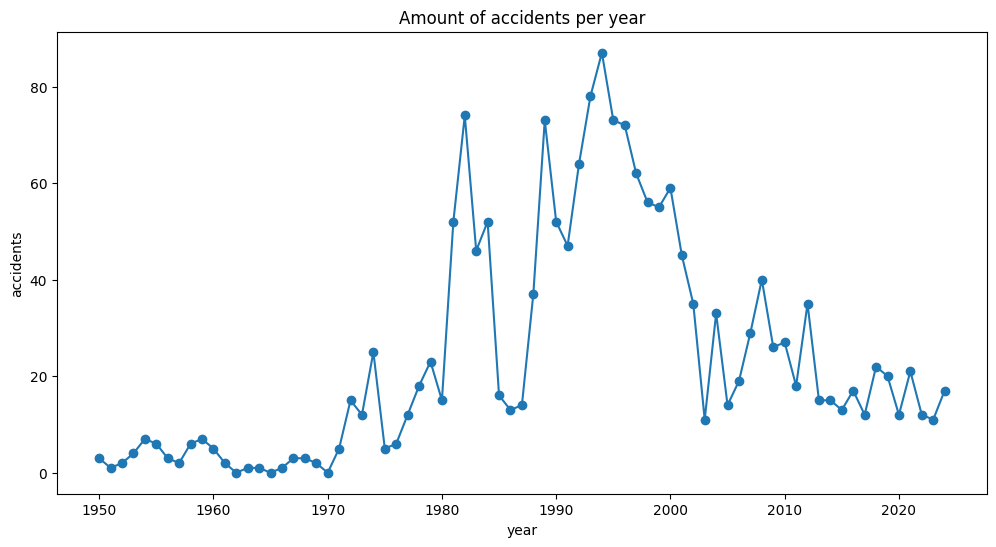

In [22]:
accidents_per_year_df_pd = accidents_per_year_df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(accidents_per_year_df_pd["year"], accidents_per_year_df_pd["total_accident_results"], marker="o")

plt.title("Amount of accidents per year")
plt.xlabel("year")
plt.ylabel("accidents")

plt.show()

This already gives a first impression of the data. It can be seen that there was an extreme increase between 1970 and 2000.

## Accident rate
In order to the reason in more detail, other factors must also be taken into account.
For that we look at the accident rate for every year.

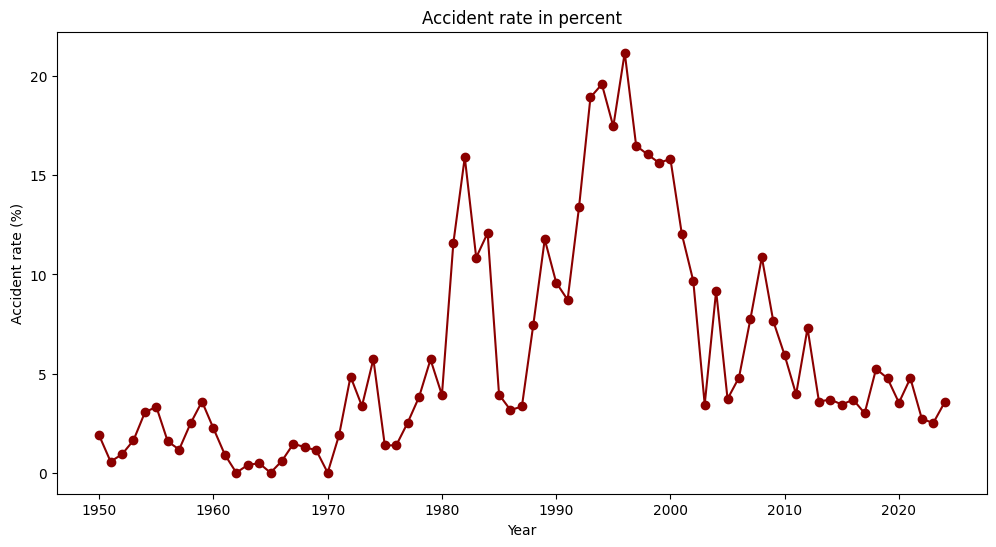

In [23]:
accidents_per_year_df_pd = accidents_per_year_df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(accidents_per_year_df_pd["year"], accidents_per_year_df_pd["accident_rate"], marker="o", color="darkred")

plt.title("Accident rate in percent")
plt.xlabel("Year")
plt.ylabel("Accident rate (%)")

plt.show()

Now the data looks already a bit different.
There is still an increase in the years 1970 - 2000 but it is way less extreme.

## Differentiation of accident categories
In a next step, we would like to analyse the three accident of interest mentioned above.

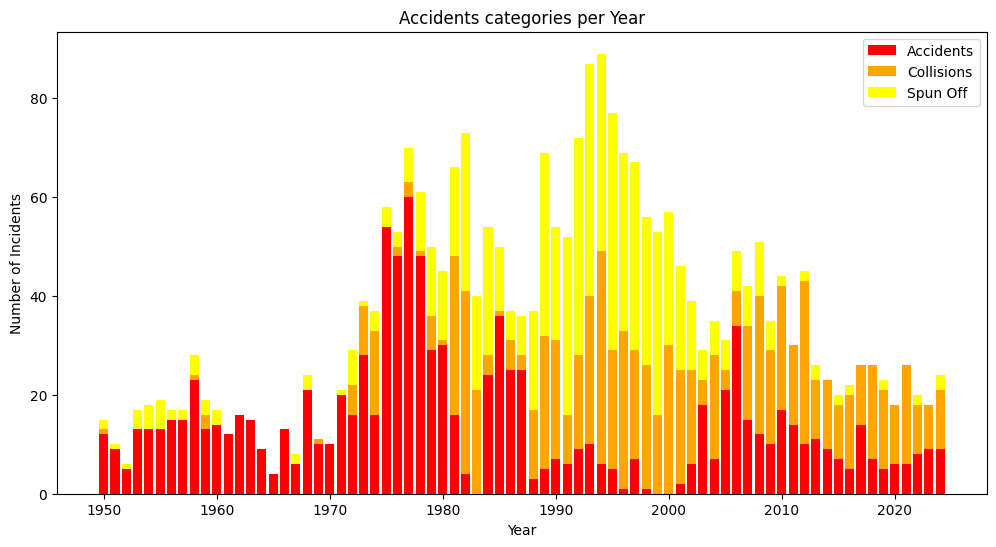

In [24]:
accidents_per_year_df_pd = accidents_per_year_df.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(accidents_per_year_df_pd['year'], accidents_per_year_df_pd['accident_results'], color='red', label='Accidents')
plt.bar(accidents_per_year_df_pd['year'], accidents_per_year_df_pd['collision_results'], bottom=accidents_per_year_df_pd['accident_results'], color='orange', label='Collisions')
plt.bar(accidents_per_year_df_pd['year'], accidents_per_year_df_pd['spun_off_results'],
        bottom=accidents_per_year_df_pd['accident_results'] + accidents_per_year_df_pd['collision_results'],
        color='yellow', label='Spun Off')

plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Accidents categories per Year')
plt.legend()

plt.show()

This visualisation reveals even more details of the accidents. It can be seen that the increase in the number of accidents is actually an increase in the number of spun offs and collisions and that the amount of `accident` stats has actually fallen.

There could be various reasons for this. For example, there may have been adjustments to the classification, incidents may have been categorised differently. However, we do not have the expertise to explain the exact reasons for this change.

# 2. Which driver had the most accidents?

In this analysis we want to find out which driver had the most accidents.

To do this, we first need to select the relevant information. The following steps were taken to do this:
1. Join the drivers to the results
2. Group the results by the drivers
3. Aggregate the informations
    - forename and surname
    - count all the results of the driver
    - count all the accitens of the driver
    - count all accidents that are registered as accident of the driver
    - count all accidents that are registered as collisions of the driver
    - count all accidents that are registered as spun off of the driver
    - calculate the accident rate in relation to all results of this driver

In [25]:
results_driver_df = results_df.join(
        drivers_df.select("driverId", "forename", "surname"),
        on="driverId",
        how="inner"
    ).groupBy("driverId") \
    .agg(
        first("forename").alias("forename"),
        first("surname").alias("surname"),
        count("*").alias("total_results"),
        sum(when(col("statusId").isin(status_ids_of_interest), 1).otherwise(0)).alias("total_accident_results"),
        sum(when(col("statusId") == 3, 1).otherwise(0)).alias("accident_results"),
        sum(when(col("statusId") == 4, 1).otherwise(0)).alias("collision_results"),
        sum(when(col("statusId") == 20, 1).otherwise(0)).alias("spun_off_results"),
        round((sum(when(col("statusId").isin(status_ids_of_interest), 1).otherwise(0)) / count("*")) * 100, 2).alias("accident_rate"))

## Absolute numbers
Firstly, we look at the drivers who have had the most accidents in absolute terms.

In [26]:
accident_drivers_absolute_df = results_driver_df.orderBy(
        col("total_accident_results").desc()
    ).select(
        "forename",
        "surname",
        "total_accident_results")

accident_drivers_absolute_df.show(truncate=False, n=20)

+------------+-----------+----------------------+
|forename    |surname    |total_accident_results|
+------------+-----------+----------------------+
|Rubens      |Barrichello|31                    |
|Ukyo        |Katayama   |30                    |
|Martin      |Brundle    |30                    |
|Andrea      |de Cesaris |30                    |
|Jean        |Alesi      |29                    |
|Johnny      |Herbert    |29                    |
|Giancarlo   |Fisichella |27                    |
|David       |Coulthard  |26                    |
|Michael     |Schumacher |26                    |
|Nigel       |Mansell    |26                    |
|Riccardo    |Patrese    |26                    |
|Eddie       |Irvine     |25                    |
|Ralf        |Schumacher |24                    |
|Pedro       |Diniz      |24                    |
|Jarno       |Trulli     |23                    |
|Olivier     |Panis      |22                    |
|Pierluigi   |Martini    |21                    |


## Accident rate
Then we look at all drivers with he highest accident rate.

In [27]:
drivers_accident_rate_df = results_driver_df.orderBy(
        col("accident_rate").desc(), col("total_results").desc()
    ).select(
        "forename",
        "surname",
        "accident_rate",
        "total_results")

drivers_accident_rate_df.show(truncate=False, n=20)

+--------+----------+-------------+-------------+
|forename|surname   |accident_rate|total_results|
+--------+----------+-------------+-------------+
|Stéphane|Sarrazin  |100.0        |1            |
|Marco   |Apicella  |100.0        |1            |
|Don     |Edmunds   |100.0        |1            |
|Jimmy   |Stewart   |100.0        |1            |
|Stefan  |Bellof    |50.0         |22           |
|Franck  |Lagorce   |50.0         |2            |
|Philippe|Adams     |50.0         |2            |
|Al      |Pease     |50.0         |2            |
|Hermann |Lang      |50.0         |2            |
|Noritake|Takahara  |50.0         |2            |
|Eppie   |Wietzes   |50.0         |2            |
|Roger   |Williamson|50.0         |2            |
|Jackie  |Holmes    |50.0         |2            |
|Michael |Andretti  |46.15        |13           |
|Tommy   |Byrne     |40.0         |5            |
|Taki    |Inoue     |33.33        |18           |
|Hideki  |Noda      |33.33        |3            |


As you can see, there were many drivers who only competed in one race and had an accident in that race.

**Info**: An interesting sight is Roger Williamson, who had an accident in his first two races and unfortunately died in the second (https://en.wikipedia.org/wiki/Roger_Williamson)

For a more exciting result, we set the minimum number of races to 20 in a second step

In [ ]:
drivers_accident_rate_df.filter(col("total_results") >= 20).show(truncate=False, n=20)

+----------+-----------+-------------+-------------+
|forename  |surname    |accident_rate|total_results|
+----------+-----------+-------------+-------------+
|Stefan    |Bellof     |50.0         |22           |
|Ukyo      |Katayama   |30.93        |97           |
|Pedro     |Diniz      |24.24        |99           |
|Mark      |Blundell   |23.81        |63           |
|Ricardo   |Rosset     |23.33        |30           |
|Toranosuke|Takagi     |21.88        |32           |
|Manfred   |Winkelhock |21.82        |55           |
|Eliseo    |Salazar    |21.62        |37           |
|Satoru    |Nakajima   |21.25        |80           |
|Zsolt     |Baumgartner|20.0         |20           |
|Alexander |Wurz       |18.84        |69           |
|Pedro     |Lamy       |18.75        |32           |
|Luis      |Pérez-Sala |18.75        |32           |
|Sébastien |Bourdais   |18.52        |27           |
|Ricardo   |Zonta      |18.42        |38           |
|Martin    |Brundle    |18.18        |165     

Now the table is a lot more meaningful, as all the drivers have contested a few races.

## Differentiation of accident categories
The last thing we look at is the different accidents categories.

For that we look at the top 20 drivers with the highest accident rate which have at least 20 race results.

In [37]:
drivers_accident_rate_20_races_df = results_driver_df.filter(
        col("total_results") >= 20
    ).orderBy(col("accident_rate").desc(), col("total_results").desc())

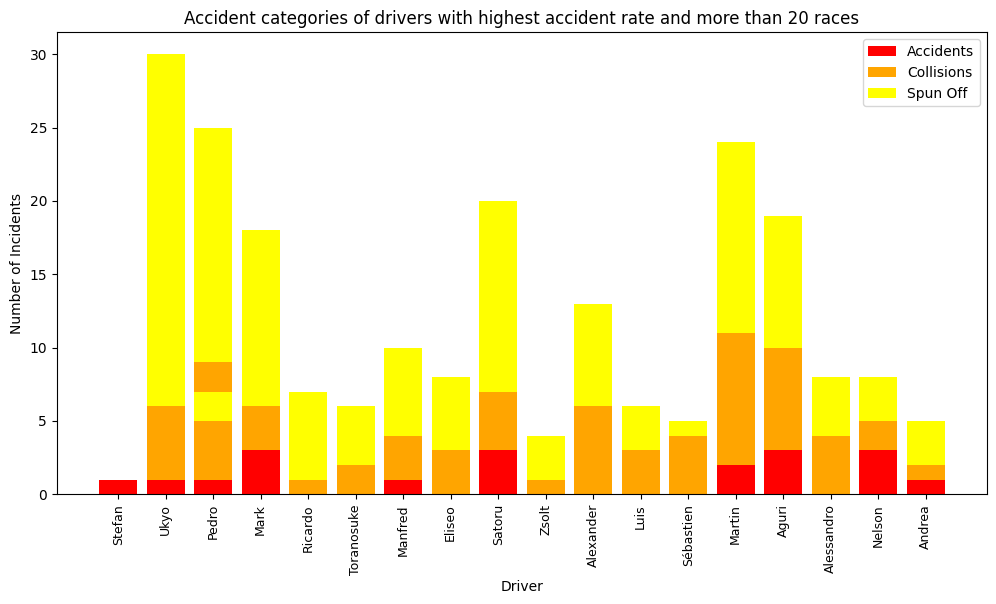

In [30]:
drivers_accident_rate_20_races_df_pd = drivers_accident_rate_20_races_df.limit(20).toPandas()

# gestapelte Balken zeichnen
plt.figure(figsize=(12, 6))
plt.bar(drivers_accident_rate_20_races_df_pd['forename'], drivers_accident_rate_20_races_df_pd['accident_results'], color='red', label='Accidents')
plt.bar(drivers_accident_rate_20_races_df_pd['forename'], drivers_accident_rate_20_races_df_pd['collision_results'], bottom=drivers_accident_rate_20_races_df_pd['accident_results'], color='orange', label='Collisions')
plt.bar(drivers_accident_rate_20_races_df_pd['forename'], drivers_accident_rate_20_races_df_pd['spun_off_results'],
        bottom=drivers_accident_rate_20_races_df_pd['accident_results'] + drivers_accident_rate_20_races_df_pd['collision_results'],
        color='yellow', label='Spun Off')

# Achsentitel und Legende
plt.xlabel('Driver')
plt.ylabel('Number of Incidents')
plt.title('Accident categories of drivers with highest accident rate and more than 20 races')
plt.legend()
plt.xticks(rotation=90, fontsize=9)

plt.show()

# 3. Which team had the most accidents?
In this analysis we want to find out which team had the most accidents.

To do this, we first need to select the relevant information. The following steps were taken to do this:
1. Join the constructors (teams) to the results
2. Group the results by the teams
3. Aggregate the informations
    - team name
    - count all the results per team
    - count all the accitens per team
    - count all accidents that are registered as accident per team
    - count all accidents that are registered as collisions per team
    - count all accidents that are registered as spun off per team
    - calculate the accident rate in relation to all results per team

In [31]:
results_constructors_df = results_df.join(
        constructors_df.select("constructorId", "name"),
        on="constructorId",
        how="inner"
    ).groupBy("constructorId") \
    .agg(
        first("name").alias("name"),
        count("*").alias("total_results"),
        sum(when(col("statusId").isin(status_ids_of_interest), 1).otherwise(0)).alias("total_accident_results"),
        sum(when(col("statusId") == 3, 1).otherwise(0)).alias("accident_results"),
        sum(when(col("statusId") == 4, 1).otherwise(0)).alias("collision_results"),
        sum(when(col("statusId") == 20, 1).otherwise(0)).alias("spun_off_results"),
        round((sum(when(col("statusId").isin(status_ids_of_interest), 1).otherwise(0)) / count("*")) * 100, 2).alias("accident_rate"))

## Absolute numbers
Again first we look at the teams who have had the most accidents in absolute terms.

In [32]:
top_accident_teams_absolute_df = results_constructors_df.orderBy(
        col("total_accident_results").desc()
    ).select(
        "name",
        "total_accident_results")

top_accident_teams_absolute_df.show(truncate=False, n=20)

+-----------+----------------------+
|name       |total_accident_results|
+-----------+----------------------+
|Williams   |133                   |
|McLaren    |132                   |
|Tyrrell    |117                   |
|Ferrari    |111                   |
|Sauber     |94                    |
|Minardi    |94                    |
|Jordan     |78                    |
|Benetton   |73                    |
|Ligier     |70                    |
|Team Lotus |69                    |
|Arrows     |65                    |
|Renault    |60                    |
|Footwork   |39                    |
|Brabham    |37                    |
|Toro Rosso |36                    |
|Force India|33                    |
|Alfa Romeo |31                    |
|Red Bull   |30                    |
|Prost      |24                    |
|Mercedes   |23                    |
+-----------+----------------------+
only showing top 20 rows



## Accident rate
Then we look at the teams with the highest accident rate.

In [33]:
teams_accident_rate_df = results_constructors_df.orderBy(
        col("accident_rate").desc(), col("total_results").desc()
    ).select(
        "name",
        "accident_rate",
        "total_results")

teams_accident_rate_df.show(truncate=False, n=20)

+------------+-------------+-------------+
|name        |accident_rate|total_results|
+------------+-------------+-------------+
|Ferguson    |100.0        |2            |
|Olson       |100.0        |1            |
|Kojima      |33.33        |3            |
|Trojan      |25.0         |8            |
|Token       |25.0         |4            |
|Frazer Nash |25.0         |4            |
|Footwork    |20.1         |194          |
|Jordan      |15.6         |500          |
|Eagle-Climax|15.38        |13           |
|Prost       |14.55        |165          |
|MF1         |14.29        |28           |
|Benetton    |14.04        |520          |
|Minardi     |13.99        |672          |
|Tyrrell     |13.28        |881          |
|ATS         |12.96        |162          |
|Forti       |12.96        |54           |
|Jaguar      |12.94        |170          |
|Dallara     |12.5         |144          |
|Spyker MF1  |12.5         |8            |
|Boro        |12.5         |8            |
+----------

Here again we have the problem with teams that have only taken part in a few races.

We therefore only filter for teams that have achieved at least 100 results.

In [38]:
team_accident_rate_over_100_df = teams_accident_rate_df.filter(col("total_results") >= 100)
team_accident_rate_over_100_df.show(truncate=False,n=20)

+-----------+-------------+-------------+
|name       |accident_rate|total_results|
+-----------+-------------+-------------+
|Footwork   |20.1         |194          |
|Jordan     |15.6         |500          |
|Prost      |14.55        |165          |
|Benetton   |14.04        |520          |
|Minardi    |13.99        |672          |
|Tyrrell    |13.28        |881          |
|ATS        |12.96        |162          |
|Jaguar     |12.94        |170          |
|Dallara    |12.5         |144          |
|Ligier     |11.46        |611          |
|Sauber     |11.23        |837          |
|Arrows     |11.02        |590          |
|Larrousse  |9.72         |216          |
|BAR        |8.47         |236          |
|Williams   |7.94         |1676         |
|Team Lotus |7.92         |871          |
|Force India|7.78         |424          |
|Renault    |7.62         |787          |
|Alfa Romeo |6.87         |451          |
|Toleman    |6.87         |131          |
+-----------+-------------+-------

Many of the current teams that we have seen in the table of absolute numbers have disappeared here because they have had a lot of accidents, because they have been in Formula 1 for a long time.

## Accident rate of current teams
As a final analysis, let's take a look at the accident rates of all the teams which participated 2024.

To get the current teams, we have to:
1. Get all the `raceId`s of 2024
1. Select all results which include these race

In [44]:

race_ids_2024_df = races_df.filter(col("year") == 2024).select("raceId").distinct()
current_teams = results_df.join(race_ids_2024_df, on="raceId", how="inner").join(
    constructors_df.select("constructorId", "name"),
    on="constructorId",
    how="inner"
).select("name").distinct()

teams_accident_rate_df.join(current_teams, on="name", how="inner").filter(
        (col("total_results") >= 100)
    ).orderBy(
        col("accident_rate").desc()
    ).show(truncate=False, n=20)

+--------------+-------------+-------------+
|name          |accident_rate|total_results|
+--------------+-------------+-------------+
|Sauber        |11.23        |837          |
|Williams      |7.94         |1676         |
|McLaren       |6.86         |1923         |
|Haas F1 Team  |5.53         |380          |
|Ferrari       |4.55         |2439         |
|Red Bull      |3.81         |788          |
|Mercedes      |3.53         |652          |
|Alpine F1 Team|2.78         |180          |
|Aston Martin  |2.62         |191          |
+--------------+-------------+-------------+



# Conclusion

## Has the sport become safer over time?
If you look at the absolute numbers of accidents or accidents rate, it seems that the sport became much more dangerous between 1970 and 2000, and that it's now as safe as it was at the beginning. On the other hand, if you look at the different classifications of _accidents_, there seems to be a significant change. The number of _accidents_ classified as such decreased rapidly, while the number of _collisions_ increased quickly, followed by the number of spun offs. Unfortunately, we have no information of how these accidents occurred or whether the drivers suffered any injuries.

But one assumption we have is that the classification accident is worse than spun off and collision. This would also be consistent with the number of deaths, which fell dramatically after 1970. [List of Formula One fatalities (Wikipedia)](https://en.wikipedia.org/wiki/List_of_Formula_One_fatalities)

## Which driver had the most accidents?
Andrea de Cesaris is the driver who had the most accidents in absolute terms. In his racing days, this earned him many nicknames such as ‘Andrea de Crasheris’ or ‘Mozart of destruction’. But of course the absolute figures distort the picture a little. Drivers who have competed in many races are more likely to be shown here than drivers with only a few races.

Therefore the statistics on drivers with at least 20 races, sorted by their accident rate, is much more meaningful. Ukyo Katayama is leading these statistic. He drove in F1 in the 90s and impressed with good qualifying results, which he then lost in the race due to technical problems or accidents, most of which were not his fault. [Ukyo_Katayama (Wikipedia)](https://en.wikipedia.org/wiki/Ukyo_Katayama)

## Which team had the most accidents?
Looking at the list of teams with the most accidents in absolute terms, we can see many old teams, such as Ferrari and McLaren. Ferrari has been competing in F1 since 1950, and McLaren since 1966. So it is not surprising that these teams top this particular statistic.

If we look at the accident rate of teams that had at least 100 results, we can see the Team Footwork Arrows. They competed in F1 from 1991 to 1996. They managed to achieve an accident rate of over 20 percent. In second place, we can see the Team Jordan Grand Prix, in which Andrea de Cesaris, the driver with the most accidents in absolute terms, also drove.